# Final Project

## Setup

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tqdm import tqdm

from IPython import display

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu,True)
    except RuntimeError as e:
        print(e)

2023-12-08 13:13:29.049398: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-08 13:13:29.072767: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 13:13:30.357914: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-12-08 13:13:33.560290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

In [2]:
train_GAN = False
train_original_classifier = False
train_GAN_classifier = True

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

In [4]:
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = tf.image.resize(train_images, [64, 64])
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
# train_images = (train_images - 0.5) / 0.5

2023-12-08 13:13:34.096221: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 13:13:34.096330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 13:13:34.096373: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128
noise_dim = 100

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## DCGAN Network

In [7]:
def make_generator_model(image_widthheight):
    initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.02)
    batch_initializer = tf.keras.initializers.RandomNormal(mean=1, stddev=0.02)
    zeror = tf.keras.initializers.Zeros()
    model = tf.keras.Sequential()
    # model.add(layers.Dense(image_widthheight//8*image_widthheight//8*image_widthheight*4, use_bias=False, input_shape=(100,)))
    # model.add(layers.BatchNormalization())
    # model.add(layers.ReLU())

    # model.add(layers.Reshape((image_widthheight//8, image_widthheight//8, image_widthheight*4)))
    # assert model.output_shape == (None, image_widthheight//8, image_widthheight//8, image_widthheight*4)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(image_widthheight*8, (4, 4), strides=(1, 1), use_bias=False, input_shape=(1,1,100), kernel_initializer=initializer))
    # assert model.output_shape == (None, image_widthheight//8, image_widthheight//8, image_widthheight*4)
    model.add(layers.BatchNormalization(gamma_initializer=batch_initializer, beta_initializer=zeror))
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(image_widthheight*4, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=initializer))
    # assert model.output_shape == (None, image_widthheight//4, image_widthheight//4, image_widthheight*2)
    model.add(layers.BatchNormalization(gamma_initializer=batch_initializer, beta_initializer=zeror))
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(image_widthheight*2, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=initializer))
    # assert model.output_shape == (None, image_widthheight//4, image_widthheight//4, image_widthheight*2)
    model.add(layers.BatchNormalization(gamma_initializer=batch_initializer, beta_initializer=zeror))
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(image_widthheight, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=initializer))
    # assert model.output_shape == (None, image_widthheight//2, image_widthheight//2, image_widthheight)
    model.add(layers.BatchNormalization(gamma_initializer=batch_initializer, beta_initializer=zeror))
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=initializer, activation='tanh'))
    # assert model.output_shape == (None, image_widthheight, image_widthheight, 3)

    return model

In [8]:
def make_discriminator_model(image_widthheight):
    initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=0.02)
    batch_initializer = tf.keras.initializers.RandomNormal(mean=1, stddev=0.02)
    zeror = tf.keras.initializers.Zeros()
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(image_widthheight, (4, 4), strides=(2, 2), padding='same', kernel_initializer=initializer,
                                     input_shape=[image_widthheight, image_widthheight, 3]))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(image_widthheight*2, (4, 4), strides=(2, 2), padding='same', kernel_initializer=initializer))
    model.add(layers.BatchNormalization(gamma_initializer=batch_initializer, beta_initializer=zeror))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(image_widthheight*4, (4, 4), strides=(2, 2), padding='same', kernel_initializer=initializer))
    model.add(layers.BatchNormalization(gamma_initializer=batch_initializer, beta_initializer=zeror))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(image_widthheight*8, (4, 4), strides=(2, 2), padding='same', kernel_initializer=initializer))
    model.add(layers.BatchNormalization(gamma_initializer=batch_initializer, beta_initializer=zeror))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(1, (4, 4), strides=(2, 2), kernel_initializer=initializer, activation="sigmoid"))

    return model

In [9]:
generator = make_generator_model(64)

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         819200    
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 4, 4, 512)         2048      
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 256)         2097152   
 Transpose)                                                      
                                                                 
 batch_normalization_1 (Bat  (None, 8, 8, 256)         1024      


 chNormalization)                                                
                                                                 
 re_lu_1 (ReLU)              (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 16, 16, 128)       524288    
 Transpose)                                                      
                                                                 
 batch_normalization_2 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 re_lu_2 (ReLU)              (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 32, 32, 64)        131072    
 Transpose)                                                      
                                                                 
 batch_nor

/home/cbeam18/.local/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [10]:
discriminator = make_discriminator_model(64)

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_4 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544    
                                                      

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)

In [12]:
import matplotlib.pyplot as plt
from IPython import display

seed = tf.random.normal([49, 1, 1, noise_dim])

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(7, 7))

  for i in range(49):
      plt.subplot(7, 7, i+1)
      plt.imshow((predictions[i] + 1) / 2)
      plt.axis('off')

  plt.savefig('outputs2/image_at_epoch_{:04d}.png'.format(epoch))
  # plt.show()
  plt.close()

In [13]:
train_log_dir = 'logs/dcgan2_64'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

@tf.function
def train_step(images):
    noises = tf.random.normal([BATCH_SIZE, 1, 1, noise_dim])
    with tf.GradientTape() as disc_tape:
        generated_images = generator(noises, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)

    with tf.GradientTape() as gen_tape:
        generated_images = generator(noises, training=True)
        fake_output = discriminator(generated_images, training=True)
        g_loss = generator_loss(fake_output)
        gen_loss = g_loss

    grad_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grad_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train(dataset, epochs):
    resize_layer = tf.keras.layers.Resizing(64, 64)
    for epoch in tqdm(range(epochs)):
        # start = time.time()
        for batch in dataset:
            gen_loss, disc_loss = train_step(batch)
            # train_step(resize_layer(batch))
        
        print(f"Epoch {epoch+1}, Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}")
        generate_and_save_images(generator, epoch, seed)
        # print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        with train_summary_writer.as_default():
            tf.summary.scalar('gen loss', gen_loss, step=epoch)
            tf.summary.scalar('disc loss', disc_loss, step=epoch)

In [14]:
if train_GAN:
  train(train_dataset, 55)

In [15]:
if train_GAN:
  generator.save_weights("models/generator_64.ckpt")
  discriminator.save_weights("models/discriminator_64.ckpt")
else:
  generator.load_weights("models/generator_64.ckpt")
  discriminator.load_weights("models/discriminator_64.ckpt")

## MobileNet V2 - No GAN inputs

In [16]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = tf.image.resize(train_images, (64, 64))

In [17]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomFlip("vertical"),
        keras.layers.RandomZoom(height_factor=0.1,width_factor=0.1)
    ]
)

In [18]:
base_mobile_model = keras.applications.MobileNetV2(
    weights="imagenet",
    input_shape=(128,128,3),
    include_top=False
)

base_mobile_model.trainable = False

inputs = keras.Input(shape=(64,64,3))
x = data_augmentation(inputs)

scaled_layer = keras.layers.Rescaling(scale=1/255.0)
resize_layer = tf.keras.layers.Resizing(128, 128)
x = resize_layer(scaled_layer(x))

x = base_mobile_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(10)(x)
mobile_model = keras.Model(inputs, outputs)

mobile_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 resizing (Resizing)         (None, 128, 128, 3)       0         
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

In [19]:
if train_original_classifier:
  keras.backend.clear_session()
  mobile_model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'],
  )

  logdir = os.path.join("logs", "original_classifier_64")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  epochs = 20
  mobile_model.fit(train_images, train_labels, batch_size=128, epochs=epochs) #, callbacks=[tensorboard_callback])

In [20]:
if train_original_classifier:
  keras.backend.clear_session()
  base_mobile_model.trainable = True

  mobile_model.compile(
      optimizer=keras.optimizers.Adam(1e-5),
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'],
  )

  mobile_model.fit(train_images, train_labels, batch_size=128, epochs=10) #, callbacks=[tensorboard_callback])

In [21]:
if train_original_classifier:
  mobile_model.save_weights("models/mobile_model_64.ckpt")
else:
  mobile_model.load_weights("models/mobile_model_64.ckpt")

## Training New Model

In [22]:
base_mobile_modelB = keras.applications.MobileNetV2(
    weights="imagenet",
    input_shape=(128,128,3),
    include_top=False
)

base_mobile_modelB.trainable = False

inputs = keras.Input(shape=(64,64,3))
x = data_augmentation(inputs)

scaled_layer = keras.layers.Rescaling(scale=1/255.0)
resize_layer = tf.keras.layers.Resizing(128, 128)
x = resize_layer(scaled_layer(x))

x = base_mobile_modelB(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(10)(x)
modelB = keras.Model(inputs, outputs)

modelB.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 resizing_1 (Resizing)       (None, 128, 128, 3)       0         
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                 

In [23]:
custom_ds = tf.keras.utils.image_dataset_from_directory("fake_dataset2", labels="inferred", batch_size=128, image_size=(64, 64), shuffle=False)

Found 10000 files belonging to 10 classes.


In [24]:
custom_images = tf.convert_to_tensor(np.concatenate([x for x,y in custom_ds], axis=0))
custom_labels = (np.concatenate([y for x,y in custom_ds], axis=0))

In [25]:
custom_labels = custom_labels.astype(np.float32).astype(np.uint8)

In [26]:
train_images2 = tf.concat([train_images, custom_images], axis=0)
train_labels2 = np.concatenate([train_labels, np.vstack(custom_labels)], axis=0)

In [27]:
if train_GAN_classifier:
  keras.backend.clear_session()
  modelB.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'],
  )

  logdir = os.path.join("logs", "gan_classifier2_64")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  epochs = 20
  modelB.fit(train_images2, train_labels2, batch_size=128, epochs=epochs, callbacks=[tensorboard_callback])

Epoch 1/20


2023-12-08 13:13:45.246991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700
2023-12-08 13:13:45.341014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-08 13:13:45.379863: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc0e71bfdd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-08 13:13:45.379878: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-12-08 13:13:45.382247: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-08 13:13:45.433326: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

469/469 [==============================] - 10s 19ms/step - loss: 1.5451 - accuracy: 0.4506
Epoch 2/20
469/469 [==============================] - 9s 20ms/step - loss: 1.3296 - accuracy: 0.5283
Epoch 3/20
469/469 [==============================] - 9s 19ms/step - loss: 1.2905 - accuracy: 0.5448
Epoch 4/20
469/469 [==============================] - 9s 19ms/step - loss: 1.2708 - accuracy: 0.5469
Epoch 5/20
469/469 [==============================] - 9s 19ms/step - loss: 1.2740 - accuracy: 0.5472
Epoch 6/20
469/469 [==============================] - 9s 19ms/step - loss: 1.2578 - accuracy: 0.5535
Epoch 7/20
469/469 [==============================] - 9s 19ms/step - loss: 1.2519 - accuracy: 0.5550
Epoch 8/20
469/469 [==============================] - 9s 19ms/step - loss: 1.2503 - accuracy: 0.5568
Epoch 9/20
469/469 [==============================] - 9s 19ms/step - loss: 1.2478 - accuracy: 0.5585
Epoch 10/20
469/469 [==============================] - 9s 19ms/step - loss: 1.2526 - accuracy: 0.5581

In [28]:
if train_GAN_classifier:
  keras.backend.clear_session()
  base_mobile_modelB.trainable = True

  modelB.compile(
      optimizer=keras.optimizers.Adam(1e-5),
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'],
  )

  modelB.fit(train_images2, train_labels2, batch_size=128, epochs=10, callbacks=[tensorboard_callback])

Epoch 1/10


469/469 [==============================] - 31s 43ms/step - loss: 1.0597 - accuracy: 0.6242
Epoch 2/10
469/469 [==============================] - 19s 41ms/step - loss: 0.9050 - accuracy: 0.6798
Epoch 3/10
469/469 [==============================] - 19s 41ms/step - loss: 0.8270 - accuracy: 0.7058
Epoch 4/10
469/469 [==============================] - 19s 41ms/step - loss: 0.7649 - accuracy: 0.7271
Epoch 5/10
469/469 [==============================] - 19s 41ms/step - loss: 0.7298 - accuracy: 0.7400
Epoch 6/10
469/469 [==============================] - 20s 42ms/step - loss: 0.6921 - accuracy: 0.7518
Epoch 7/10
469/469 [==============================] - 19s 41ms/step - loss: 0.6652 - accuracy: 0.7617
Epoch 8/10
469/469 [==============================] - 19s 41ms/step - loss: 0.6387 - accuracy: 0.7736
Epoch 9/10
469/469 [==============================] - 19s 41ms/step - loss: 0.6152 - accuracy: 0.7800
Epoch 10/10
469/469 [==============================] - 19s 41ms/step - loss: 0.6003 - accurac

In [29]:
if train_GAN_classifier:
  modelB.save_weights("models/modelB2_64.ckpt")
else:
  modelB.load_weights("models/modelB2_64.ckpt")

## Compare Against Test Dataset

In [30]:
keras.backend.clear_session()
(_, _), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
test_images = tf.image.resize(test_images, (64, 64))

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)

In [31]:
class_accuracy_original = keras.metrics.Accuracy()
class_accuracy_gan = keras.metrics.Accuracy()

true_stack = []
orig_stack = []
gan_stack = []
for batch in test_dataset:
    batch_size = len(batch[0])
    pred_orig = mobile_model(batch[0], training=False)
    pred_gan = modelB(batch[0], training=False)

    label_orig = tf.reshape(tf.cast(tf.math.argmax(pred_orig, axis=1), dtype=tf.uint8), (batch_size, 1))
    label_gan = tf.reshape(tf.cast(tf.math.argmax(pred_gan, axis=1), dtype=tf.uint8), (batch_size, 1))

    class_accuracy_original.update_state(batch[1], label_orig)
    class_accuracy_gan.update_state(batch[1], label_gan)

    true_stack.append(batch[1])
    orig_stack.append(label_orig)
    gan_stack.append(label_gan)

print(f"Oringinal Accuracy: {class_accuracy_original.result().numpy()}, GAN Classifier Accuracy: {class_accuracy_gan.result().numpy()}")

Oringinal Accuracy: 0.8892999887466431, GAN Classifier Accuracy: 0.8842999935150146


In [32]:
tf.math.confusion_matrix(
    tf.unstack(tf.concat(true_stack, axis=0), axis=1)[0], 
    tf.unstack(tf.concat(orig_stack, axis=0), axis=1)[0], num_classes=10
)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[912,   6,   4,   4,   3,   0,   0,   4,  43,  24],
       [  3, 937,   0,   0,   0,   0,   0,   0,   3,  57],
       [ 27,   2, 870,  28,  34,   9,  12,  14,   3,   1],
       [  7,   7,  27, 795,  19,  99,  11,  18,   9,   8],
       [  2,   1,  26,  16, 874,  11,   8,  58,   3,   1],
       [  2,   0,  11,  95,  15, 842,   3,  25,   2,   5],
       [  7,   4,  18,  42,  24,  15, 875,   5,   6,   4],
       [ 14,   2,   7,  16,  35,  23,   2, 894,   2,   5],
       [ 27,  18,   1,   0,   1,   1,   1,   1, 936,  14],
       [  5,  31,   0,   0,   0,   0,   0,   1,   5, 958]], dtype=int32)>

In [33]:
tf.math.confusion_matrix(
    tf.unstack(tf.concat(true_stack, axis=0), axis=1)[0], 
    tf.unstack(tf.concat(gan_stack, axis=0), axis=1)[0], num_classes=10
)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[878,  11,   8,   2,   2,   1,   2,   8,  62,  26],
       [  4, 954,   0,   0,   0,   0,   0,   0,   5,  37],
       [ 22,   7, 828,  26,  27,  16,  42,  22,   9,   1],
       [  7,  10,  18, 731,  20, 121,  52,  19,   9,  13],
       [  4,   1,  18,  16, 846,  18,  27,  67,   3,   0],
       [  1,   2,   9,  63,  14, 857,   9,  37,   3,   5],
       [  4,   4,  12,  11,   8,   6, 949,   0,   4,   2],
       [ 10,   2,   4,   9,  27,  20,   5, 912,   4,   7],
       [ 17,  16,   1,   0,   0,   1,   1,   1, 945,  18],
       [  4,  44,   0,   0,   0,   0,   0,   1,   8, 943]], dtype=int32)>

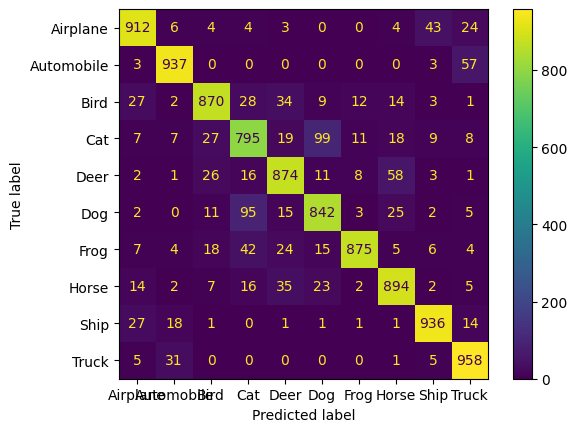

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

cm = confusion_matrix(
    y_true=tf.unstack(tf.concat(true_stack, axis=0), axis=1)[0].numpy(), 
    y_pred=tf.unstack(tf.concat(orig_stack, axis=0), axis=1)[0].numpy(), 
    labels=class_labels
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
    display_labels=class_names)
disp.plot()
plt.show()
plt.close()

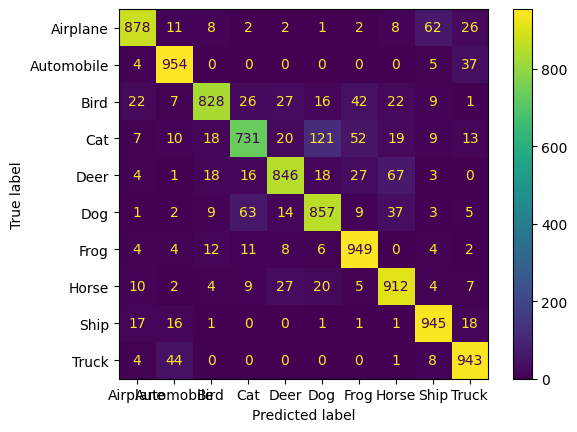

: 

In [35]:
class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

cm = confusion_matrix(
    y_true=tf.unstack(tf.concat(true_stack, axis=0), axis=1)[0].numpy(), 
    y_pred=tf.unstack(tf.concat(gan_stack, axis=0), axis=1)[0].numpy(), 
    labels=class_labels
)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
    display_labels=class_names)
disp.plot()
plt.show()
plt.close()